#### Clustering: 
The goal is to group similar instances together into clusters. This is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, and more.

#### Anomaly Detection:
The objective is to learn what "normal" data looks like, and use this to detect abnormal instances, such as defective items on a production line or a new trend in a time series.

#### Density Estimation:
This is the task of estimating the probability density function of the random process that generated the dataset. This is commonly used for anomaly detection: instances located in very low-density regions are likely to be anomalies. It is also useful for data analysis and visualization. 

### K-Means

In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

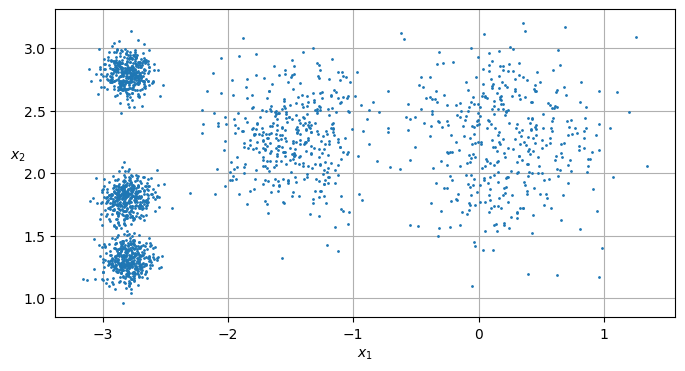

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()

plt.show()

In [3]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

In [4]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [5]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

In [6]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

The K-Means Algorithm works by randomly assinging the centroids and then label the instances and update the centroids and label the instance and so on until the centroids stop moving. The algorithm is guaranteed to converge in a finite number of steps, it will not oscillate forever.

Unfortunately, although the algorithm is guaranteed to converge, it may not converge to the right solution as this depends on the centroid intialization.


#### Centroid Initialization Methods

We can ran another clustering algorithm earlier and use the centroids using the init hyperparameter and set n_init to 1.

Another solution is to run the algorithm multiple times with different random initializations and keep the best solution. This is controlled by n_init. Default value is 10.

In [7]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

#### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. 

In [8]:
kmeans.inertia_

211.5985372581684

The score() method returns the negative inertia because a predictor's score() method must always respect the "great is better" rule.

An important improvement to the K-Means algorithm, called K-Means++ introduced a smarter initialization step that tends to select centroids that are distant from one another, and this makes the K-Means algorithm much less likely to converge to a sub-optimal solution.

The KMeans class actually uses this initialization method by default. We can use the original method i.e. picking k instances randomly, by setting the init hyperparameter to random.


#### Accelerated K-Means and Mini-batch K-Means

We can accelerate the algorithm by avoiding unnecessary distance calculation (using triangle inequality) and by keeping track of lower and upper bounds for distances between instances and centroids. This is the algorithm used by the default KMeans class but we can use the original algorithm by setting the algorithm hyperparametr to full.

Instead of using the full dataset at each iteration, the algorithm is capable of using the mini-batches, moving the centroids just slighlty at each iteration. This speeds up the algorithm typically by a factor of 3 or 4. Scikit-Learn implements this algorithm in the MiniBatchKMeans class. 

In [9]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

In [10]:
minibatch_kmeans.inertia_

211.66830891212575

Mini-batch K-Means  algorithm is much faster than the regular K-Means algorithms, its inertia is generally slightly worse, especially as the number of clusters increases.


#### Finding the Optimal Number of Clusters

We cannot simply take the value of k that minimizes the inertia, since it keeps getting lower as we increase k. However, we can plot the inertia as a function of k and analyze the resulting curve.

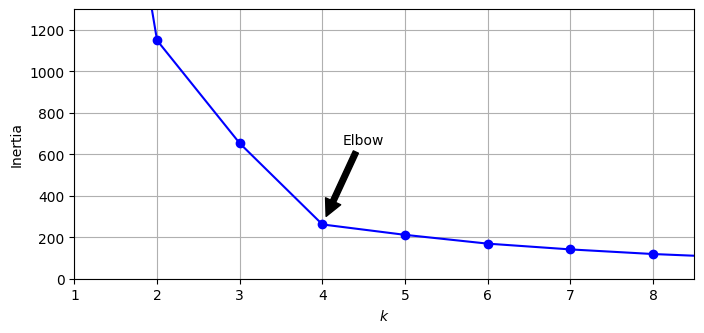

In [11]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
plt.show()

But as we know there are 5 clusters, so this is also not good way.

Another approach is to look at the silhouette score, which is the mean silhouette coefficient over all the instances. An instance's silhouette coefficient is equal to (b - a) / max(a, b) where a is the mean distance to the other instances in the same cluster and b is the mean nearest-cluster distance. Silhouette coefficient close to +1 means that the instance is well inside its own cluster, while close to 0 means that it is close to a cluster boundary, and close to -1 means that the instance may have been assigned to the wrong cluster.

In [12]:
from sklearn.metrics import silhouette_score

In [13]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

#### Limits of K-Means

K-Means doesn't behave very well when the clusters have varying sizes, different densities, or non-spherical shapes.

It is important to scale the input features before you run K-Means, or else the clusters may be very stretched, and K-Means will perform poorly.



#### Using clustering for Image Segmentation

Image Segmentation is the task of partitioning an image into multiple segments. In semantic segmentation, all pixels that are part of the same object type get assigned to the same segment. 

In [14]:
from matplotlib.image import imread

image = imread("image/ladybug.jpg")

In [15]:
image.shape

(950, 1024, 3)

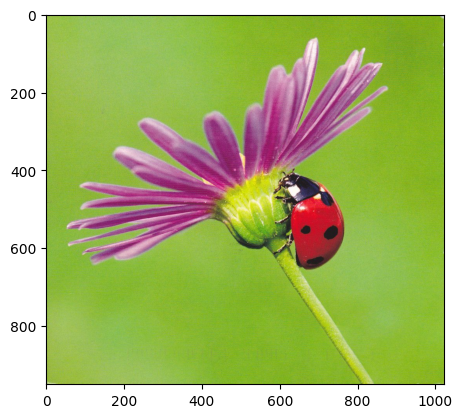

In [16]:
plt.imshow(image)
plt.show()

In [17]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

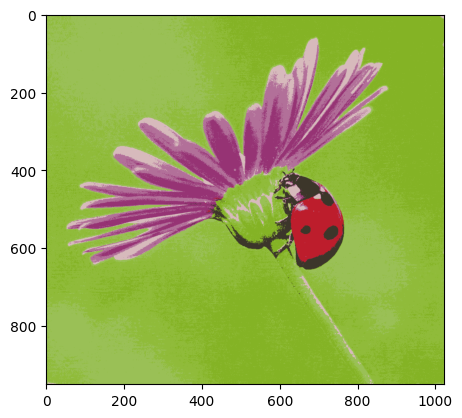

In [18]:
plt.imshow(segmented_img/255)
plt.show()

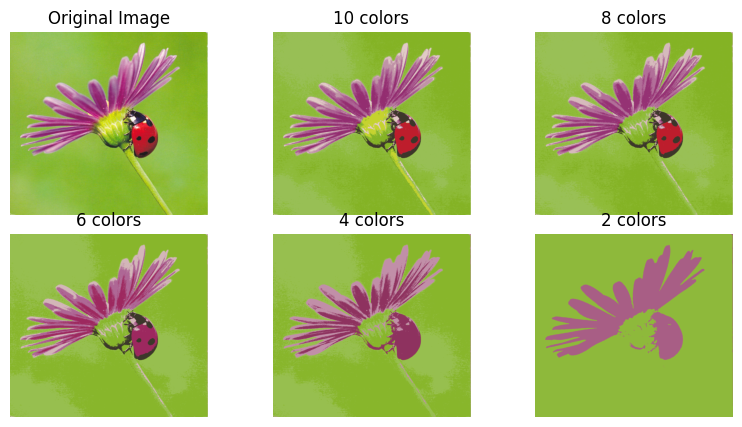

In [19]:
segmented_imgs = []
n_colors= (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_img = segmented_img.reshape(image.shape)
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 3, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} colors")
    plt.axis("off")

plt.show()

#### Using Clustering for Preprocessing

Clustering can be an efficient approach to dimensionality reduction.

In [20]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"], train_size=100)

In [22]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [23]:
log_reg.score(X_test, y_test)

0.7432761087267525

In [24]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50)),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42)),
    
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [25]:
pipeline.score(X_test, y_test)

0.7437052932761087

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(20, 60))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END ..............................kmeans__n_clusters=20; total time=   0.1s
[CV] END ..............................kmeans__n_clusters=20; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=20; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=21; total time=   0.1s
[CV] END ..............................kmeans__n_clusters=21; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=21; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=22; total time=   0.1s
[CV] END ..............................kmeans__n_clusters=22; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=22; total time=   0.1s
[CV] END ..............................kmeans__n_clusters=23; total time=   0.1s
[CV] END ..............................kmeans__n_clusters=23; total time=   0.2s
[CV] END ..............................kmeans__

[CV] END ..............................kmeans__n_clusters=53; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=54; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=54; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=54; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=55; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=55; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=55; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=56; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=56; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=56; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=57; total time=   0.2s
[CV] END ..............................kmeans__n_clusters=57; total time=   0.3s
[CV] END ...................

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(20, 60)}, verbose=2)

In [27]:
grid_clf.best_params_

{'kmeans__n_clusters': 58}

In [28]:
grid_clf.score(X_test, y_test)

0.7201859799713877

#### Using Clustering for Semi-Supervised Learning

We can use use clustering in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

In [29]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

In [30]:
n_labeled = 50
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=1000)

In [31]:
log_reg.score(X_test, y_test)

0.7481108312342569

In [32]:
k = 50
kmeans=KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)

In [33]:
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

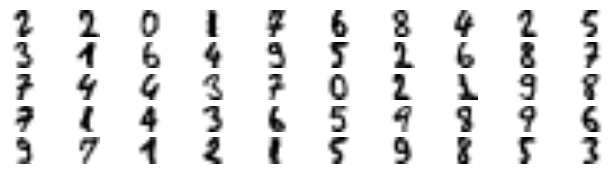

In [34]:
plt.figure(figsize=(8, 2))

for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

plt.show()

In [35]:
y_representative_digits = np.array([
    2, 2, 0, 1, 7, 6, 8, 4, 2, 5,
    3, 1, 6, 4, 9, 5, 2, 6, 8, 7,
    7, 4, 4, 3, 7, 0, 2, 1, 9, 8,
    7, 1, 4, 3, 6, 5, 9, 8, 9, 6,
    9, 7, 1, 2, 1, 5, 9, 8, 5, 3,
])


log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8413098236775819

#### Label Propagation is a technique to propagate the lavels to all the other instances in the same cluster.

In [36]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [37]:
kmeans.labels_

array([ 2,  3, 43, ..., 22, 22, 19])

In [38]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

D:\ML\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.9017632241813602

In [39]:
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [40]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

D:\ML\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8942065491183879

### DBSCAN

It stands for Density Based Spatial Clustering of Applications with Noise. 

For each instance, it counts how many instances are located within a small distance epsilon from it. 

If an instance has at least min_samples instances in its epsilon neighborhood (including itself), then it is considered a core instance.

All instances in the neighborhood of the core instance belong to the same cluster. This may include other core instance, therefore a long sequence of neighboring core instances forms a single cluster.

Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.

This algorithm works well if all the clusters are dense enough, and they are well separated by low-density regions.

In [4]:
%matplotlib inline
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt


X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

[]

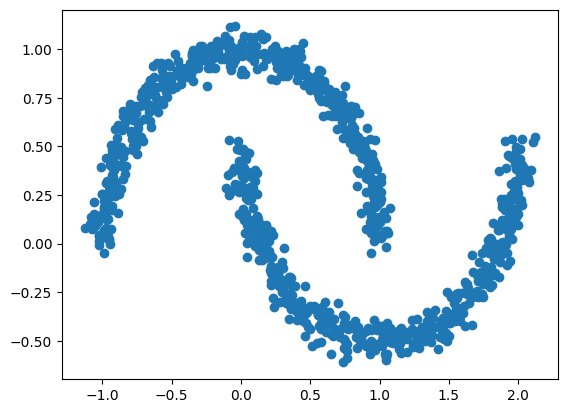

In [5]:
plt.scatter(X[:, 0], X[:, 1])

plt.plot()

In [6]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

In [7]:
dbscan.core_sample_indices_

array([  0,   1,   2,   3,   6,   7,   8,   9,  10,  12,  14,  16,  17,
        18,  19,  20,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  34,  35,  37,  38,  39,  40,  41,  42,  43,  44,  45,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  80,  81,  82,  84,  85,  86,  87,  88,  89,  90,  91,
        93,  94,  95,  96,  98, 100, 101, 102, 103, 104, 105, 106, 108,
       110, 112, 114, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126,
       127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141,
       143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 183, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201,
       202, 204, 205, 206, 207, 209, 210, 211, 212, 213, 215, 21

In [8]:
dbscan.components_

array([[-0.08941877,  0.9959914 ],
       [ 0.45761172,  0.81423188],
       [-0.67903146,  0.77094911],
       ...,
       [ 0.96681248,  0.41078708],
       [ 0.47591047,  0.82514798],
       [ 0.25429868,  0.93648807]])

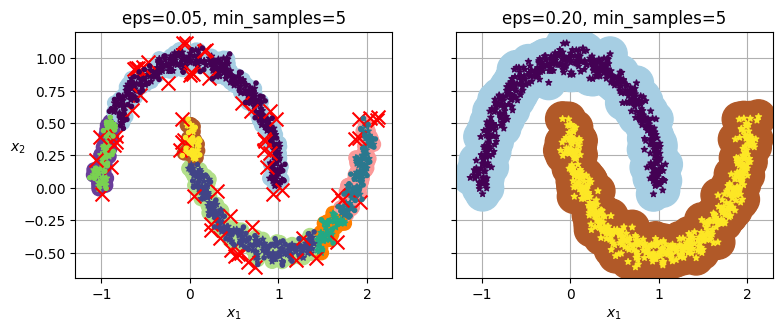

In [9]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

As DBSCAN class does not have a `predict()` method. So we can train a classifier model and predict the point lies in which cluster.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [11]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([4, 5, 0, 2], dtype=int64)

In [12]:
knn.predict_proba(X_new)

array([[0.  , 0.16, 0.  , 0.  , 0.78, 0.06],
       [0.02, 0.28, 0.  , 0.  , 0.  , 0.7 ],
       [0.76, 0.24, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  ]])

### Other Clustering Algorithms:

#### Agglomerative Clustering

Initialize the Proximitiy matrix. Make each point a cluster. Inside a loop: Merge the two closest cluster. Update the Proximity Matrix until only one cluster is left.


In [19]:
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=500, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)


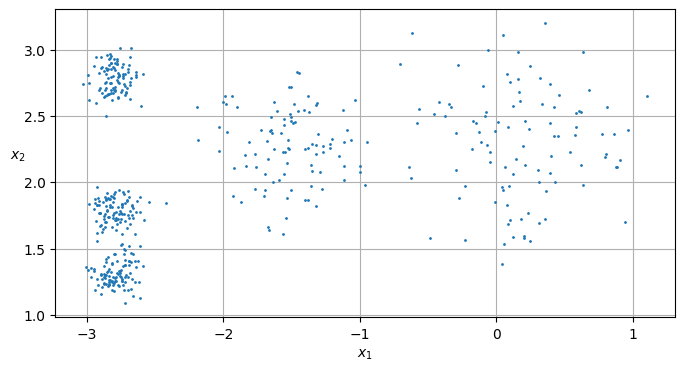

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()

plt.show()

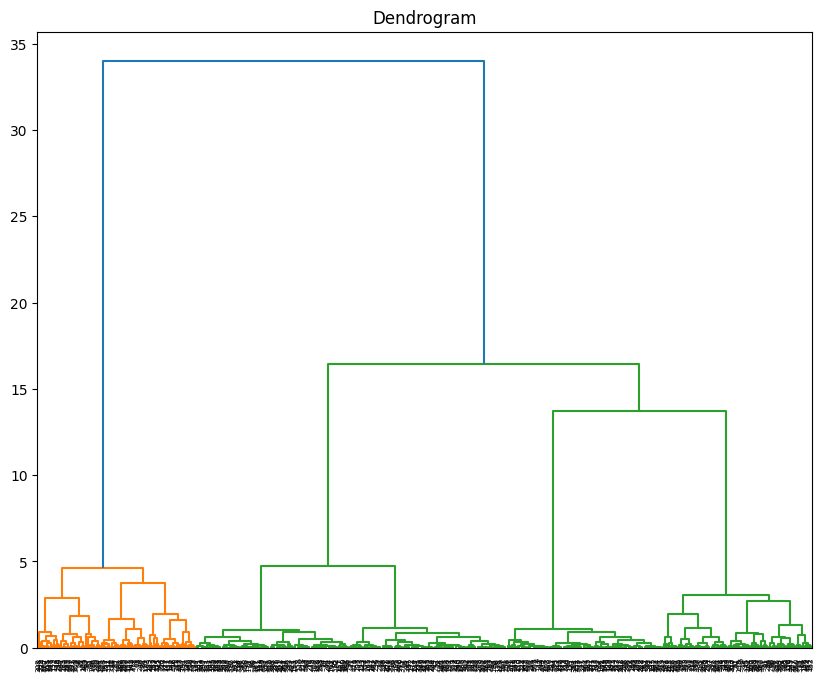

In [21]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 8))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

In [27]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
labels_ = cluster.fit_predict(X)

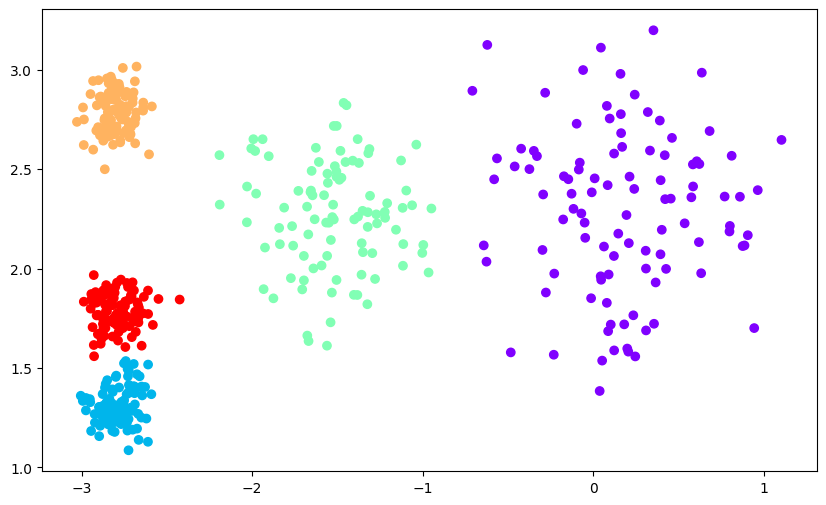

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_, cmap='rainbow')

If we have n instances then our proximity matrix will be of n x n order. So, it will take large memory space.

#### Mean-shift

It is very similar to the K-Means algorithm, except that we don't need to specify the number of groups prior to training.

It starts by placing a circle centered on each instance, then it computes the mean of all the instances located within it, and it shifts the circle so that it is centered on the mean. It iterates this mean-shift step until all the circles stop moving. 

Its computational complexity is O(m2), so it is not suited for large datasets.

In [41]:
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=1000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

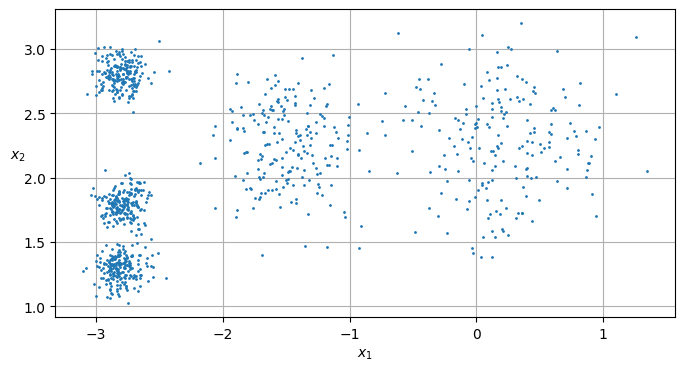

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()

plt.show()

In [68]:
from sklearn.cluster import MeanShift

ms = MeanShift(bandwidth=0.5)
ms.fit(X)

MeanShift(bandwidth=0.5)

In [69]:
ms.cluster_centers_

array([[-2.79720164,  1.54211371],
       [-2.80248802,  2.8023078 ],
       [-1.49588441,  2.25832025],
       [ 0.19729879,  2.36123744]])

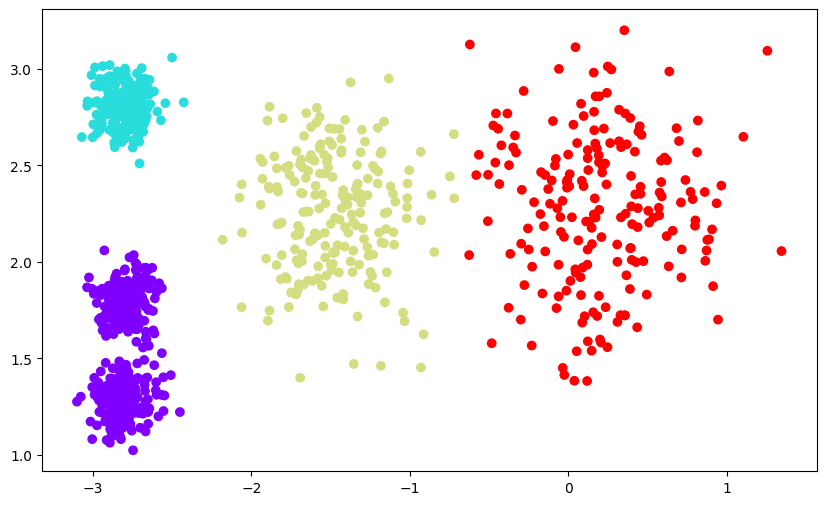

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=ms.labels_, cmap='rainbow')